# Estimación de la densidad del kernel
**Nombre:** Juan Manuel Gutiérrez Gómez  **Código:** 2260563

En la sección anterior, cubrimos los modelos de mezcla gaussiana (GMM), que son una especie de híbrido entre un estimador de agrupamiento y un estimador de densidad. Recuerde que un estimador de densidad es un algoritmo que toma un conjunto de datos de dimensión-$D$ y produce una estimación de la distribución de probabilidad de dimensión-$D$ de la que se extraen esos datos. El algoritmo GMM logra esto al representar la densidad como una suma ponderada de distribuciones gaussianas. La *estimación de la densidad del núcleo* (KDE) es, en algunos sentidos, un algoritmo que lleva la idea de la mezcla de gaussianas a su extremo lógico: utiliza una mezcla que consta de un componente gaussiano por punto, lo que da como resultado un estimador de densidad esencialmente no paramétrico. En esta sección, exploraremos la motivación y los usos de KDE.

Comenzamos con las importaciones estándar:

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np

## Motivando KDE: Histogramas

Como ya se discutió, un estimador de densidad es un algoritmo que busca modelar la distribución de probabilidad que generó un conjunto de datos. Para datos unidimensionales, probablemente ya esté familiarizado con un estimador de densidad simple: el histograma. Un histograma divide los datos en contenedores discretos, cuenta la cantidad de puntos que caen en cada contenedor y luego visualiza los resultados de una manera intuitiva.

Por ejemplo, creemos algunos datos extraídos de dos distribuciones normales:

In [2]:
def make_data(N, f=0.3, rseed=1):
    rand = np.random.RandomState(rseed)
    x = rand.randn(N)
    x[int(f * N):] += 5
    return x

x = make_data(1000)

Anteriormente hemos visto que el histograma estándar basado en recuento se puede crear con la función **plt.hist()**. Al especificar el parámetro normed del histograma, obtenemos un histograma normalizado en el que la altura de los contenedores no refleja los recuentos, sino la densidad de probabilidad:

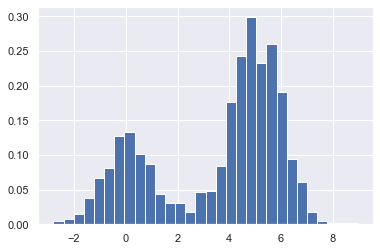

In [3]:
hist = plt.hist(x, bins=30, density=True, stacked=True)

Tenga en cuenta que para la distribución equitativa, esta normalización simplemente cambia la escala en el eje y, dejando las alturas relativas esencialmente iguales que en un histograma creado a partir de conteos. Esta normalización se elige para que el área total bajo el histograma sea igual a 1, como podemos confirmar mirando la salida de la función de histograma:

In [4]:
density, bins, _ = hist
widths = bins[1:] - bins[:-1]
(density * widths).sum()

1.0

Uno de los problemas con el uso de un histograma como estimador de densidad es que la elección del tamaño y la ubicación del contenedor puede conducir a representaciones que tienen características cualitativamente diferentes. Por ejemplo, si observamos una versión de estos datos con solo 20 puntos, la elección de cómo dibujar los contenedores puede conducir a una interpretación completamente diferente de los datos. Considere este ejemplo:

In [5]:
x = make_data(20)
bins = np.linspace(-5, 10, 10)

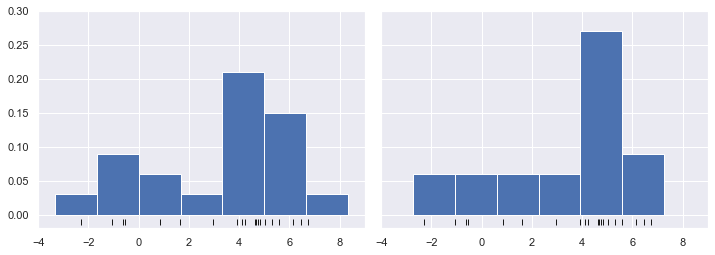

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4), sharex=True, sharey=True,
                       subplot_kw={'xlim':(-4, 9), 'ylim':(-0.02, 0.3)})
fig.subplots_adjust(wspace=0.05)
for i, offset in enumerate([0.0, 0.6]):
    ax[i].hist(x, bins=bins + offset, density=True, stacked=True)
    ax[i].plot(x, np.full_like(x, -0.01), '|k', markeredgewidth=1)

A la izquierda, el histograma deja claro que se trata de una distribución bimodal. A la derecha, vemos una distribución unimodal con una cola larga. Sin ver el código anterior, probablemente no adivinaría que estos dos histogramas se construyeron a partir de los mismos datos: con eso en mente, ¿cómo puede confiar en la intuición que confieren los histogramas? ¿Y cómo podríamos mejorar esto?

Retrocediendo, podemos pensar en un histograma como una pila de bloques, donde apilamos un bloque dentro de cada contenedor encima de cada punto en el conjunto de datos. Veamos esto directamente:

(-0.2, 8.0)

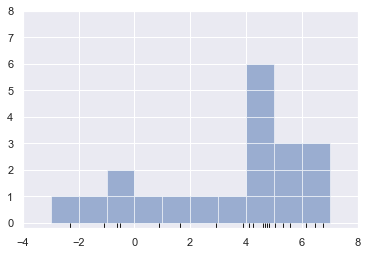

In [7]:
fig, ax = plt.subplots()
bins = np.arange(-3, 8)
ax.plot(x, np.full_like(x, -0.1), '|k',
        markeredgewidth=1)
for count, edge in zip(*np.histogram(x, bins)):
    for i in range(count):
        ax.add_patch(plt.Rectangle((edge, i), 1, 1,
                                   alpha=0.5))
ax.set_xlim(-4, 8)
ax.set_ylim(-0.2, 8)

El problema con nuestros dos agrupamientos surge del hecho de que la altura de la pila de bloques a menudo no se refleja en la densidad real de los puntos cercanos, sino en las coincidencias de cómo los agrupamientos se alinean con los puntos de datos. Esta desalineación entre los puntos y sus bloques es una causa potencial de los malos resultados del histograma que se ven aquí. Pero, ¿y si, en lugar de apilar los bloques alineados con los contenedores , apiláramos los bloques alineados con los puntos que representan? Si hacemos esto, los bloques no estarán alineados, pero podemos sumar sus contribuciones en cada ubicación a lo largo del eje x para encontrar el resultado. Intentemos esto:

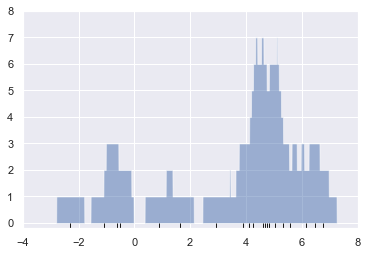

In [8]:
x_d = np.linspace(-4, 8, 2000)
density = sum((abs(xi - x_d) < 0.5) for xi in x)

plt.fill_between(x_d, density, alpha=0.5)
plt.plot(x, np.full_like(x, -0.1), '|k', markeredgewidth=1)

plt.axis([-4, 8, -0.2, 8]);

El resultado parece un poco desordenado, pero es un reflejo mucho más sólido de las características de los datos reales que el histograma estándar. Aún así, los bordes ásperos no son estéticamente agradables, ni reflejan ninguna propiedad real de los datos. Para suavizarlos, podríamos decidir reemplazar los bloques en cada ubicación con una función suave, como una gaussiana. Usemos una curva normal estándar en cada punto en lugar de un bloque:

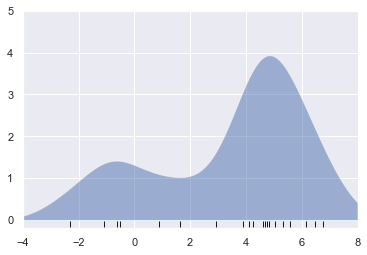

In [9]:
from scipy.stats import norm
x_d = np.linspace(-4, 8, 1000)
density = sum(norm(xi).pdf(x_d) for xi in x)

plt.fill_between(x_d, density, alpha=0.5)
plt.plot(x, np.full_like(x, -0.1), '|k', markeredgewidth=1)

plt.axis([-4, 8, -0.2, 5]);

Este gráfico suavizado, con una distribución gaussiana aportada en la ubicación de cada punto de entrada, da una idea mucho más precisa de la forma de la distribución de datos y una que tiene mucha menos variación (es decir, cambia mucho menos en respuesta a las diferencias en el muestreo).

Estos dos últimos gráficos son ejemplos de estimación de la densidad del kernel en una dimensión: el primero usa el llamado kernel "tophat" y el segundo usa un kernel gaussiano. Ahora veremos la estimación de la densidad del núcleo con más detalle.

## Estimación de la densidad del núcleo en la práctica

Los parámetros libres de estimación de la densidad del núcleo son el núcleo, que especifica la forma de la distribución colocada en cada punto, y el ancho de banda del núcleo , que controla el tamaño del núcleo en cada punto. En la práctica, hay muchos núcleos que puede usar para una estimación de la densidad del núcleo: en particular, la implementación de KDE de Scikit-Learn admite uno de los seis núcleos, sobre los que puede leer en la documentación de Estimación de la densidad de Scikit-Learn.

Si bien hay varias versiones de la estimación de la densidad del núcleo implementadas en Python (especialmente en los paquetes SciPy y StatsModels), prefiero usar la versión de Scikit-Learn debido a su eficiencia y flexibilidad. Se implementa en el estimador **sklearn.neighbors.KernelDensity**, que maneja KDE en múltiples dimensiones con uno de seis núcleos y uno de un par de docenas de métricas de distancia. Debido a que KDE puede ser bastante intensivo desde el punto de vista computacional, el estimador Scikit-Learn utiliza un algoritmo basado en árboles bajo el capó y puede compensar el tiempo de cálculo por la precisión utilizando los parámetros *__atol__(tolerancia absoluta)* y *__rtol__(tolerancia relativa)*. El ancho de banda del núcleo, que es un parámetro gratuito, se puede determinar utilizando las herramientas de validación cruzada estándar de Scikit-Learn, como veremos pronto.

Primero mostremos un ejemplo simple de replicar la gráfica anterior usando el KernelDensityestimador Scikit-Learn:

(-0.02, 0.22)

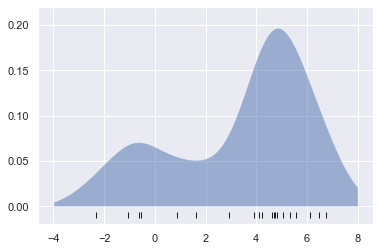

In [10]:
from sklearn.neighbors import KernelDensity

# instantiate and fit the KDE model
kde = KernelDensity(bandwidth=1.0, kernel='gaussian')
kde.fit(x[:, None])

# score_samples returns the log of the probability density
logprob = kde.score_samples(x_d[:, None])

plt.fill_between(x_d, np.exp(logprob), alpha=0.5)
plt.plot(x, np.full_like(x, -0.01), '|k', markeredgewidth=1)
plt.ylim(-0.02, 0.22)

El resultado aquí se normaliza de tal manera que el área bajo la curva es igual a 1.

## Selección del ancho de banda mediante validación cruzada

La elección del ancho de banda dentro de KDE es extremadamente importante para encontrar una estimación de densidad adecuada, y es la perilla que controla el equilibrio entre sesgo y varianza en la estimación de densidad: un ancho de banda demasiado estrecho conduce a una estimación de varianza alta (es decir, sobre-fitting), donde la presencia o ausencia de un solo punto hace una gran diferencia. Un ancho de banda demasiado amplio conduce a una estimación de alto sesgo (es decir, ajuste insuficiente) donde la estructura de los datos es eliminada por el kernel ancho.

Hay una larga historia en estadísticas de métodos para estimar rápidamente el mejor ancho de banda basado en suposiciones bastante estrictas sobre los datos: si busca las implementaciones de KDE en los paquetes SciPy y StatsModels, por ejemplo, verá implementaciones basadas en algunos de estos normas.

En contextos de aprendizaje automático, hemos visto que tal ajuste de hiperparámetros a menudo se realiza empíricamente a través de un enfoque de validación cruzada. Con esto en mente, el estimador **KernelDensity** en Scikit-Learn está diseñado de tal manera que se puede usar directamente dentro de las herramientas de búsqueda de cuadrícula estándar de Scikit-Learn. Aquí lo utilizaremos **GridSearchCV** para optimizar el ancho de banda para el conjunto de datos anterior. Debido a que estamos viendo un conjunto de datos tan pequeño, utilizaremos la validación cruzada de exclusión, que minimiza la reducción en el tamaño del conjunto de entrenamiento para cada prueba de validación cruzada:

In [11]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import LeaveOneOut

bandwidths = 10 ** np.linspace(-1, 1, 100)
grid = GridSearchCV(KernelDensity(kernel='gaussian'),
                    {'bandwidth': bandwidths},
                    cv=LeaveOneOut())
grid.fit(x[:, None]);

Ahora podemos encontrar la opción de ancho de banda que maximiza la puntuación (que en este caso tiene como valor predeterminado la probabilidad logarítmica):

In [12]:
grid.best_params_

{'bandwidth': 1.1233240329780276}

El ancho de banda óptimo resulta estar muy cerca de lo que usamos en el gráfico de ejemplo anterior, donde el ancho de banda era 1,0 (es decir, el ancho predeterminado de **scipy.stats.norm**).

## Ejemplo: KDE en una Esfera

Quizás el uso más común de KDE es representar gráficamente distribuciones de puntos. Por ejemplo, en la biblioteca de visualización de Seaborn, KDE está integrado y se usa automáticamente para ayudar a visualizar puntos en una y dos dimensiones.

Aquí veremos un uso un poco más sofisticado de KDE para la visualización de distribuciones. Haremos uso de algunos datos geográficos que se pueden cargar con Scikit-Learn: las distribuciones geográficas de las observaciones registradas de dos mamíferos sudamericanos, *Bradypus variegatus* (el perezoso de garganta marrón) y *Microryzomys minutus* (la pequeña rata arrocera del bosque).

Con Scikit-Learn, podemos obtener estos datos de la siguiente manera:

In [13]:
from sklearn.datasets import fetch_species_distributions

data = fetch_species_distributions()

# Get matrices/arrays of species IDs and locations
latlon = np.vstack([data.train['dd lat'],
                    data.train['dd long']]).T
species = np.array([d.decode('ascii').startswith('micro')
                    for d in data.train['species']], dtype='int')

Con estos datos cargados, podemos usar el kit de herramientas de **Basemap** para trazar las ubicaciones observadas de estas dos especies en el mapa de América del Sur.

In [14]:
def construct_grids(batch):
    """Construct the map grid from the batch object

    Parameters
    ----------
    batch : Batch object
        The object returned by :func:`fetch_species_distributions`

    Returns
    -------
    (xgrid, ygrid) : 1-D arrays
        The grid corresponding to the values in batch.coverages
    """
    # x,y coordinates for corner cells
    xmin = batch.x_left_lower_corner + batch.grid_size
    xmax = xmin + (batch.Nx * batch.grid_size)
    ymin = batch.y_left_lower_corner + batch.grid_size
    ymax = ymin + (batch.Ny * batch.grid_size)

    # x coordinates of the grid cells
    xgrid = np.arange(xmin, xmax, batch.grid_size)
    # y coordinates of the grid cells
    ygrid = np.arange(ymin, ymax, batch.grid_size)

    return (xgrid, ygrid)

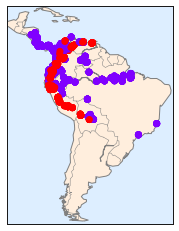

In [15]:
!pip install basemap
!pip install basemap-data
from mpl_toolkits.basemap import Basemap

xgrid, ygrid = construct_grids(data)

# plot coastlines with basemap
m = Basemap(projection='cyl', resolution='c',
            llcrnrlat=ygrid.min(), urcrnrlat=ygrid.max(),
            llcrnrlon=xgrid.min(), urcrnrlon=xgrid.max())
m.drawmapboundary(fill_color='#DDEEFF')
m.fillcontinents(color='#FFEEDD')
m.drawcoastlines(color='gray', zorder=2)
m.drawcountries(color='gray', zorder=2)

# plot locations
m.scatter(latlon[:, 1], latlon[:, 0], zorder=3,
          c=species, cmap='rainbow', latlon=True);

Desafortunadamente, esto no da una idea muy buena de la densidad de la especie, porque los puntos en el rango de la especie pueden superponerse entre sí. Puede que no te des cuenta mirando este gráfico, ¡pero aquí se muestran más de 1600 puntos!

Usemos la estimación de la densidad del kernel para mostrar esta distribución de una manera más interpretable: como una indicación suave de la densidad en el mapa. Debido a que el sistema de coordenadas aquí se encuentra en una superficie esférica en lugar de un plano plano, usaremos la métrica de distancia `haversine`, que representará correctamente las distancias en una superficie curva.

Aquí hay un poco de código repetitivo, pero el significado de cada bloque de código debe ser claro:

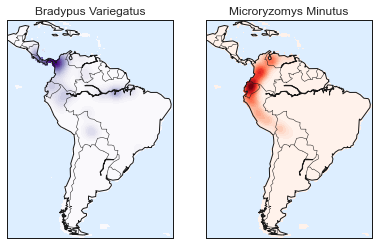

In [16]:
# Set up the data grid for the contour plot
X, Y = np.meshgrid(xgrid[::5], ygrid[::5][::-1])
land_reference = data.coverages[6][::5, ::5]
land_mask = (land_reference > -9999).ravel()
xy = np.vstack([Y.ravel(), X.ravel()]).T
xy = np.radians(xy[land_mask])

# Create two side-by-side plots
fig, ax = plt.subplots(1, 2)
fig.subplots_adjust(left=0.05, right=0.95, wspace=0.05)
species_names = ['Bradypus Variegatus', 'Microryzomys Minutus']
cmaps = ['Purples', 'Reds']

for i, axi in enumerate(ax):
    axi.set_title(species_names[i])
    
    # plot coastlines with basemap
    m = Basemap(projection='cyl', llcrnrlat=Y.min(),
                urcrnrlat=Y.max(), llcrnrlon=X.min(),
                urcrnrlon=X.max(), resolution='c', ax=axi)
    m.drawmapboundary(fill_color='#DDEEFF')
    m.drawcoastlines()
    m.drawcountries()
    
    # construct a spherical kernel density estimate of the distribution
    kde = KernelDensity(bandwidth=0.03, metric='haversine')
    kde.fit(np.radians(latlon[species == i]))

    # evaluate only on the land: -9999 indicates ocean
    Z = np.full(land_mask.shape[0], -9999.0)
    Z[land_mask] = np.exp(kde.score_samples(xy))
    Z = Z.reshape(X.shape)

    # plot contours of the density
    levels = np.linspace(0, Z.max(), 25)
    axi.contourf(X, Y, Z, levels=levels, cmap=cmaps[i])

En comparación con el diagrama de dispersión simple que usamos inicialmente, esta visualización pinta una imagen mucho más clara de la distribución geográfica de las observaciones de estas dos especies.

**Conclusiones del Ejercicio:** KDE aporta lo que no hace una distribución normal con puntos, los puntos son algo imprecisos y pueden prestarse para confusiones en un ambito real, en lugar de esto, KDE ayuda a generar una etimación mas verdadera de los datos suvizando la distribución, lo que nos muestra de manera más clara la distribución geográfica de las dos especies.

## Ejemplo: bayesiano no tan ingenuo

Este ejemplo analiza la clasificación generativa bayesiana con KDE y demuestra cómo usar la arquitectura Scikit-Learn para crear un estimador personalizado.

En Clasificación bayesiana ingenua, echamos un vistazo a la clasificación bayesiana ingenua, en la que creamos un modelo generativo simple para cada clase y usamos estos modelos para construir un clasificador rápido.
Para el bayesiano ingenuo gaussiano, el modelo generativo es un gaussiano simple alineado con el eje.
Con un algoritmo de estimación de densidad como KDE, podemos eliminar el elemento 'ingenuo' y realizar la misma clasificación con un modelo generativo más sofisticado para cada clase.
Sigue siendo una clasificación bayesiana, pero ya no es ingenua.

El enfoque general para la clasificación generativa es el siguiente:
<ol>
    <li>Divide los datos de entrenamiento por etiqueta.</li>
    <li>Para cada conjunto, ajuste un KDE para obtener un modelo generativo de los datos. Esto le permite para cualquier observación $x$ y etiquetar $y$ para calcular una probabilidad $P(x|y)$.</li>
    <li>A partir del número de ejemplos de cada clase en el conjunto de entrenamiento, calcule la clase previa, $P(y)$.</li>
    <li>Para un punto desconocido $x$, la probabilidad posterior para cada clase es $P(y | x) \propto P(x | y)P(y)$. La clase que maximiza este posterior es la etiqueta asignada al punto.</li>
</ol>
El algoritmo es sencillo e intuitivo de entender; la pieza más difícil es presentarla dentro del marco de Scikit-Learn para hacer uso de la arquitectura de búsqueda de cuadrícula y validación cruzada.

Este es el código que implementa el algoritmo dentro del marco Scikit-Learn; lo recorreremos siguiendo el bloque de código:

In [17]:
from sklearn.base import BaseEstimator, ClassifierMixin


class KDEClassifier(BaseEstimator, ClassifierMixin):
    """Bayesian generative classification based on KDE
    
    Parameters
    ----------
    bandwidth : float
        the kernel bandwidth within each class
    kernel : str
        the kernel name, passed to KernelDensity
    """
    def __init__(self, bandwidth=1.0, kernel='gaussian'):
        self.bandwidth = bandwidth
        self.kernel = kernel
        
    def fit(self, X, y):
        self.classes_ = np.sort(np.unique(y))
        training_sets = [X[y == yi] for yi in self.classes_]
        self.models_ = [KernelDensity(bandwidth=self.bandwidth,
                                      kernel=self.kernel).fit(Xi)
                        for Xi in training_sets]
        self.logpriors_ = [np.log(Xi.shape[0] / X.shape[0])
                           for Xi in training_sets]
        return self
        
    def predict_proba(self, X):
        logprobs = np.array([model.score_samples(X)
                             for model in self.models_]).T
        result = np.exp(logprobs + self.logpriors_)
        return result / result.sum(1, keepdims=True)
        
    def predict(self, X):
        return self.classes_[np.argmax(self.predict_proba(X), 1)]

Probemos este estimador personalizado en un problema que hemos visto antes: la clasificación de dígitos escritos a mano. Aquí cargaremos los dígitos y calcularemos la puntuación de validación cruzada para un rango de anchos de banda candidatos utilizando el metaestimador `GridSearchCV`:

In [18]:
from sklearn.datasets import load_digits
from sklearn.model_selection import GridSearchCV

digits = load_digits()

bandwidths = 10 ** np.linspace(0, 2, 100)
grid = GridSearchCV(KDEClassifier(), {'bandwidth': bandwidths})
grid.fit(digits.data, digits.target)

scores = grid.cv_results_['mean_test_score']

A continuación, podemos trazar la puntuación de validación cruzada en función del ancho de banda:

{'bandwidth': 6.135907273413174}
accuracy = 0.9677298050139276


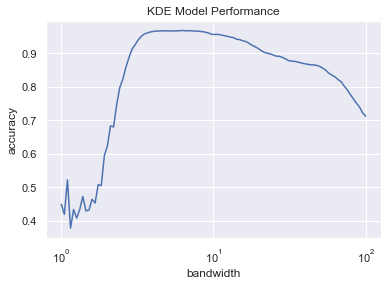

In [19]:
plt.semilogx(bandwidths, scores)
plt.xlabel('bandwidth')
plt.ylabel('accuracy')
plt.title('KDE Model Performance')
print(grid.best_params_)
print('accuracy =', grid.best_score_)

Vemos que este clasificador bayesiano no tan ingenuo alcanza una precisión de validación cruzada de poco más del 96 %; esto se compara con alrededor del 80% para la clasificación bayesiana ingenua:

In [20]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score
cross_val_score(GaussianNB(), digits.data, digits.target).mean()

0.8069281956050759

Uno de los beneficios de un clasificador generativo de este tipo es la interpretabilidad de los resultados: para cada muestra desconocida, no solo obtenemos una clasificación probabilística, sino también un modelo completo de la distribución de puntos con los que lo estamos comparando. Si lo desea, esto ofrece una ventana intuitiva a las razones de una clasificación particular que los algoritmos como SVM y bosques aleatorios tienden a oscurecer.

## Conclusión General

En rasgos genrales la estimación de densidad kernel (KDE) es menos usada que el histograma, pero puede ser una útil herramienta para mostrar la distribución de una variable. Al igual que los histogramas, los KDE codifican la densidad de observaciones en un eje mostrando una altura proporcional en el otro eje, pero los KDE pueden ser dotados de propiedades como la suavidad o continuidad.